# Visualization of CAMs

In [1]:
import tensorflow as tf
from tensorflow_addons.metrics import F1Score
import keras as ks
from keras.models import Model


from sklearn.metrics import f1_score, confusion_matrix
from skimage.color import gray2rgb
from skimage.transform import resize
import numpy as np
import pandas as pd
import time

from Utilities import *
from Augmentation import *
from Model import *

from Data.ELPV.elpv_reader import load_dataset # From ELPV GitHub


import cv2
from PIL import Image
import matplotlib.patches as patches

c:\Users\mar27\AppData\Local\anaconda3\envs\dat300_env\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Requires `grad_cam_plus` function from gradcam.py in https://github.com/samson6460/tf_keras_gradcamplusplus


In [3]:
from gradcam import grad_cam_plus

In [4]:
RESULTS_FOLDER = 'results/backup_current/'
WEIGHTSFOLDER = 'Weights/PVEL/pvel_weights_current/checkpoint.h5'

SIZE = 300

In [5]:
# Loading PVEL labels from pickle
DF = pd.read_pickle('Data/PVEL-AD/pandas_annotations') # Get the data form the images
class_names = np.loadtxt('Data/PVEL-AD/annotation_classes.txt',dtype=str) # Get the class names (defect names)
pvel_pred = pd.read_csv(RESULTS_FOLDER+'pvel_pred.csv',index_col=[0],sep=';')
colnames = pvel_pred[pvel_pred.columns[2:]].columns

for col in colnames:
    pvel_pred[col]= pvel_pred[col].apply(lambda x:np.array(list(filter(None,x[1:-1].split(' ')))).astype(float))
    
# Loading PVEL Images
pvel = load_PVEL_images(SIZE=SIZE)

pvel_labels = selectionPVEL(DF, short=6000).Label   # Gathers some classes into one and discards classes with too few samples 
                                        # as well as samples with more than one unique defect
pvel = pvel[pvel_labels.index] # Remove images with the same conditions as above
pvel = pvel/255

pvel = np.squeeze(gray2rgb(pvel))
pvel_test = pvel[pvel_pred.Inds]

Found 4500 files belonging to 1 classes.
Found 11353 files belonging to 1 classes.


In [14]:
classes = np.unique(pvel_labels)

In [15]:
preds = pvel_pred['All'].apply(lambda x: np.argmax(x))

In [16]:
pixel = [RandomSharpen(), RandomContrast((0,0.5)), RandomBrightness((-0.1,0.1), value_range=(0,1)), 
         RandomGaussianNoise(0.02)]
geometric = [RandomRot180(), RandomFlip("horizontal_and_vertical"), RandomRotation(0.01)]

In [17]:
PVEL_numclasses = 7
conv = transfer_net((SIZE,SIZE,3))
# conv = Model(conv.input, conv.get_layer('block5_conv1').output)
datagen = AugmentationBlock((SIZE,SIZE,3), geometric+pixel, make_model=True)
conv = Model(datagen.input, conv(datagen.output))
fc = DefectType(conv.output.shape[1:], PVEL_numclasses)
model = Model(conv.input, fc(conv.output))

In [18]:
model.load_weights(WEIGHTSFOLDER)

nmod = Model(model.layers[-2].input, model.layers[-1](model.layers[-2].output))

In [19]:
def add_bbxs(df, axs, dev=10, lw=1):
    if df['#'] > 0:
        lef = [int(val) for val in df.left]
        rig = [int(val) for val in df.right]
        bot = [int(val) for val in df.bottom]
        top = [int(val) for val in df.top]
        for j in range(len(bot)):
            for ax in axs:
                rect = patches.Rectangle((lef[j]-dev, top[j]-dev), rig[j]-lef[j]+dev, bot[j]-top[j]+dev,
                                            linewidth=lw, edgecolor='r', facecolor='none')
                ax.add_patch(rect)

In [20]:
test_DF = selectionPVEL(DF, short=6000).reset_index(drop=True).iloc[pvel_pred.Inds]
test_DF = test_DF.reset_index(drop=True)

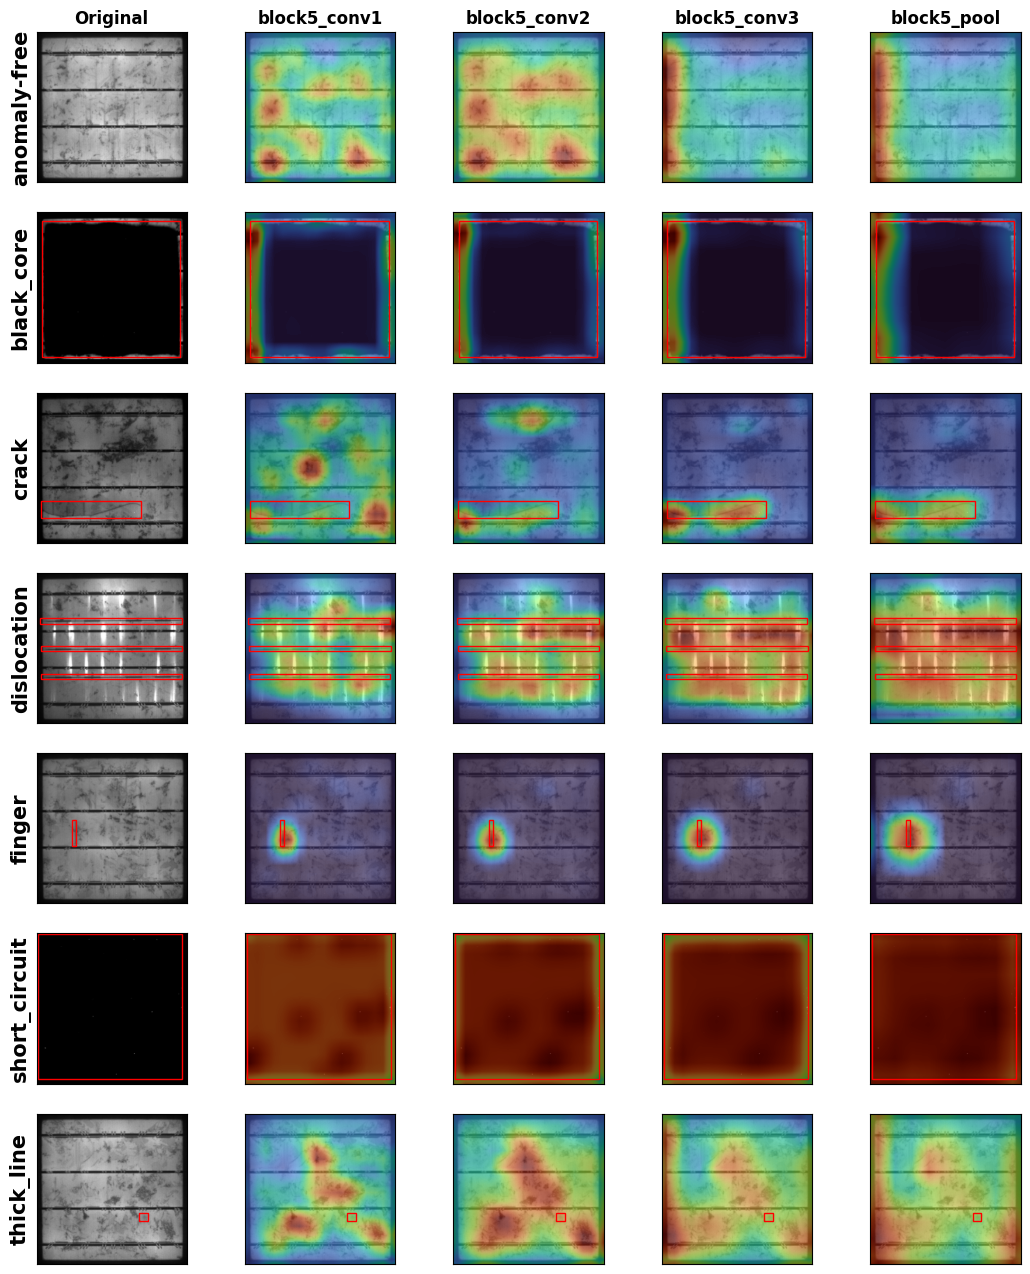

In [21]:
fig, axs = plt.subplots(7,5, figsize=(13,16))

for k, defe in enumerate(np.unique(test_DF.Label)):
    i = test_DF[test_DF['Label'] == defe].index[0]
    ax = axs[k]

    ax[0].imshow(resize(pvel_test[i], (test_DF.Resolution.iloc[i], test_DF.Resolution.iloc[i])))
    axs[0][0].set_title('Original', fontweight='bold')
    ax[0].set_ylabel(f'{classes[preds.iloc[i]]}', fontweight='bold', fontsize=15)

    for j, lay_name in enumerate(['conv1','conv2','conv3', 'pool']):
        heatmap_plus = grad_cam_plus(nmod, pvel_test[i], layer_name='block5_'+lay_name)
        heatmap_plus = resize(heatmap_plus, (SIZE,SIZE))
        heatmap_plus = rescale(heatmap_plus)

        heatmap_plus = resize(heatmap_plus, (test_DF.Resolution.iloc[i], test_DF.Resolution.iloc[i]))

        ax[j+1].imshow(resize(pvel_test[i], (test_DF.Resolution.iloc[i], test_DF.Resolution.iloc[i])))
        ax[j+1].imshow(heatmap_plus, cmap='turbo', vmin=0, vmax=1, alpha=0.5)
        axs[0][j+1].set_title('block5_'+lay_name, fontweight='bold')


    add_bbxs(test_DF.iloc[i], ax.flatten())

[no_ticks(ax) for ax in axs.flatten()]

plt.show()

In [22]:
wrong = pvel_pred['True'][pvel_pred['True'] == preds]
wrong_preds = preds[pvel_pred['True'] == preds]
wrong_soft = pvel_pred['All'][pvel_pred['True'] == preds]
wrong_imgs = pvel_test[wrong.index]
wrong_DF = test_DF.iloc[wrong.index]
classes = np.unique(pvel_labels)

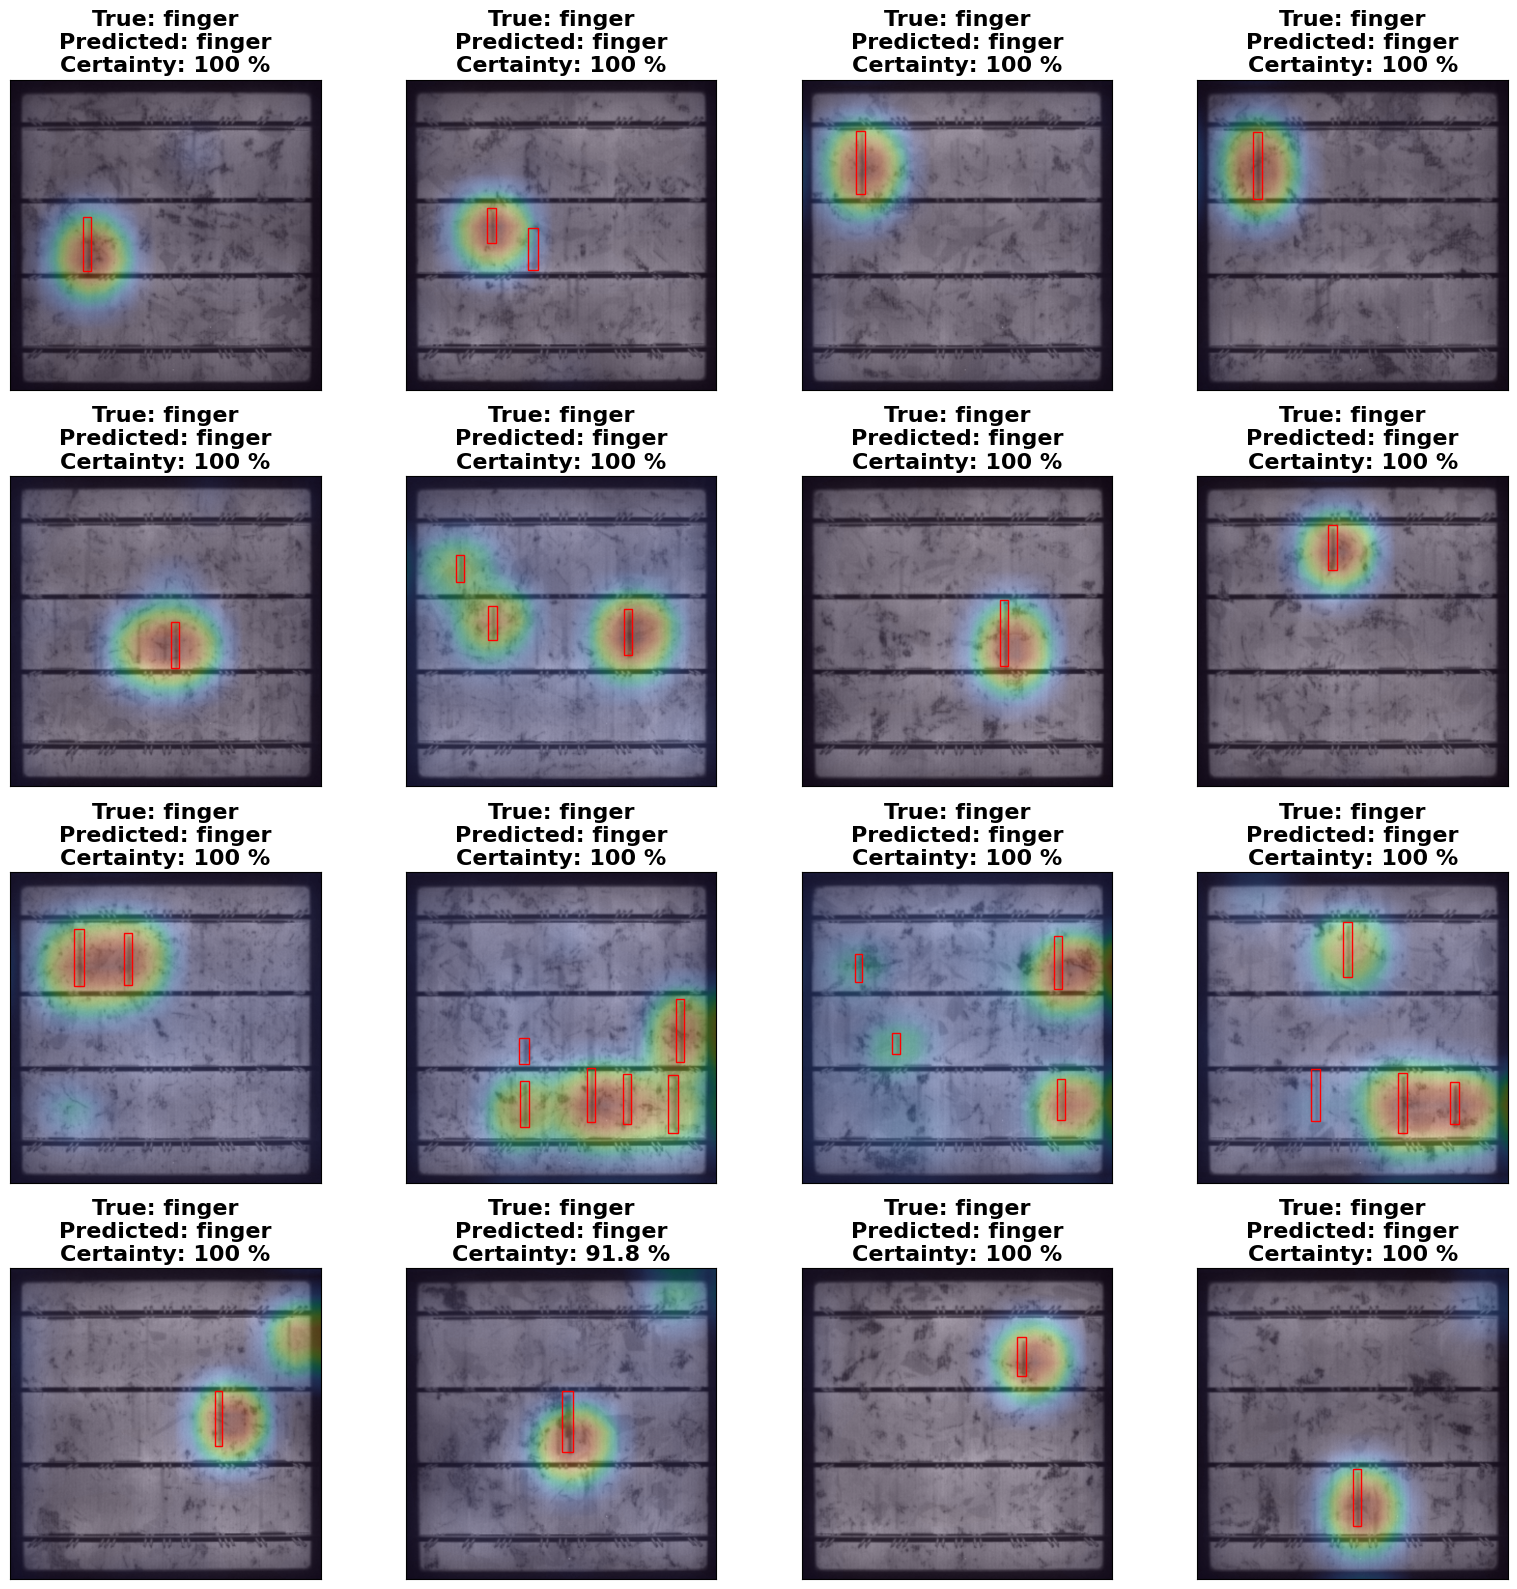

In [25]:
fig, axs = plt.subplots(4, 4, figsize=(16,4*4))
axf = axs.flatten()
i = 0

inds = np.where(wrong==4)[0][:4*4]
for ind in inds:
    prd = wrong_preds.iloc[ind]
    axf[i].set_title(f'True: {classes[4]}\nPredicted: {classes[prd]}\nCertainty: {wrong_soft.iloc[ind][prd]*100:.3g} %', fontweight='bold',
                        fontsize=16)

    heatmap_plus = grad_cam_plus(nmod, wrong_imgs[ind], layer_name='block5_conv3')
    heatmap_plus = resize(heatmap_plus, (SIZE,SIZE))
    heatmap_plus = rescale(heatmap_plus)

    heatmap_plus = resize(heatmap_plus, (wrong_DF.Resolution.iloc[ind], wrong_DF.Resolution.iloc[ind]))

    axf[i].imshow(resize(wrong_imgs[ind], (wrong_DF.Resolution.iloc[ind], wrong_DF.Resolution.iloc[ind])))
    axf[i].imshow(heatmap_plus, cmap='turbo', vmin=0, vmax=1, alpha=0.3)

    add_bbxs(wrong_DF.iloc[ind], axf[i:i+1])
    i += 1


[no_ticks(ax) for ax in axf]
plt.tight_layout()
plt.show()